# CIFAR-10 and CIFAR-100 CNN Benchmark

In this notebook, we'll benchmark CNN architectures with pooling layers on CIFAR-10 and CIFAR-100 datasets. We'll compare performance across different architectures and training methods.

## Setup and Imports

In [1]:
import sys, importlib, importlib.util
print("sys.executable:", sys.executable)
print("sys.version:", sys.version.splitlines()[0])
print("matplotlib spec:", importlib.util.find_spec("matplotlib"))
print("sys.path (first entries):", sys.path[:5])

sys.executable: /home/lukez/modula/.venv/bin/python
sys.version: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
matplotlib spec: ModuleSpec(name='matplotlib', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7ce2aa3dfdf0>, origin='/home/lukez/modula/.venv/lib/python3.10/site-packages/matplotlib/__init__.py', submodule_search_locations=['/home/lukez/modula/.venv/lib/python3.10/site-packages/matplotlib'])
sys.path (first entries): ['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/lukez/modula/.venv/lib/python3.10/site-packages']


In [2]:
import sys
import os

# Add paths for modula and data modules
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

examples_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'examples'))
sys.path.insert(0, examples_path)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

from data.cifar10 import load_cifar10
from data.cifar100 import load_cifar100
from modula.atom import Conv2D, Linear
from modula.bond import ReLU, Flatten, MaxPool2D, AvgPool2D

print("Imports successful!")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

Imports successful!
JAX version: 0.6.2
JAX devices: [CudaDevice(id=0)]


## Load CIFAR-10 Dataset

In [3]:
# Load CIFAR-10
print("Loading CIFAR-10...")
train_images_10, train_labels_10, test_images_10, test_labels_10 = load_cifar10(normalize=True)

print(f"CIFAR-10 Training images shape: {train_images_10.shape}")
print(f"CIFAR-10 Training labels shape: {train_labels_10.shape}")
print(f"CIFAR-10 Test images shape: {test_images_10.shape}")
print(f"CIFAR-10 Test labels shape: {test_labels_10.shape}")
print(f"CIFAR-10 Number of classes: {len(set(train_labels_10))}")

Loading CIFAR-10...
CIFAR-10 Training images shape: (50000, 32, 32, 3)
CIFAR-10 Training labels shape: (50000,)
CIFAR-10 Test images shape: (10000, 32, 32, 3)
CIFAR-10 Test labels shape: (10000,)
CIFAR-10 Number of classes: 10


## Load CIFAR-100 Dataset

In [4]:
# Load CIFAR-100
print("Loading CIFAR-100...")
train_images_100, train_labels_100, test_images_100, test_labels_100 = load_cifar100(normalize=True)

print(f"CIFAR-100 Training images shape: {train_images_100.shape}")
print(f"CIFAR-100 Training labels shape: {train_labels_100.shape}")
print(f"CIFAR-100 Test images shape: {test_images_100.shape}")
print(f"CIFAR-100 Test labels shape: {test_labels_100.shape}")
print(f"CIFAR-100 Number of classes: {len(set(train_labels_100))}")

Loading CIFAR-100...
CIFAR-100 Training images shape: (50000, 32, 32, 3)
CIFAR-100 Training labels shape: (50000,)
CIFAR-100 Test images shape: (10000, 32, 32, 3)
CIFAR-100 Test labels shape: (10000,)
CIFAR-100 Number of classes: 100


## Visualize Sample Images

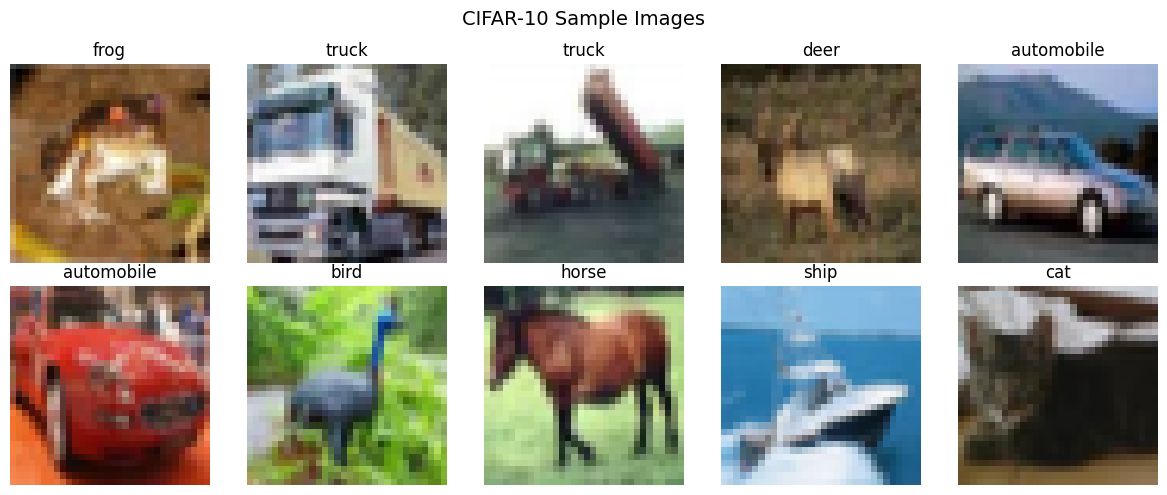

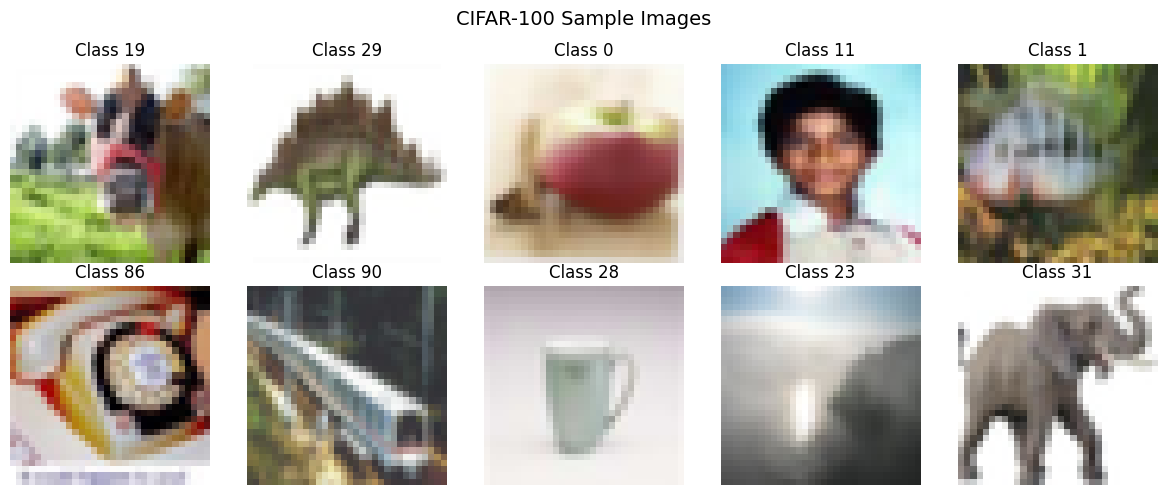

In [5]:
# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize CIFAR-10 samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('CIFAR-10 Sample Images', fontsize=14)

for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(train_images_10[i])
    axes[row, col].set_title(f'{cifar10_classes[train_labels_10[i]]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Visualize CIFAR-100 samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('CIFAR-100 Sample Images', fontsize=14)

for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(train_images_100[i])
    axes[row, col].set_title(f'Class {train_labels_100[i]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Data Preparation

Convert images to JAX arrays and create one-hot encoded labels.

In [6]:
def one_hot(labels, num_classes, dtype=jnp.float32):
    """Create one-hot encoding of labels."""
    return jnp.array(labels[:, None] == jnp.arange(num_classes), dtype)

# Prepare CIFAR-10 data
X_train_10 = jnp.asarray(train_images_10, dtype=jnp.float32)
y_train_10 = one_hot(train_labels_10, 10)
X_test_10 = jnp.asarray(test_images_10, dtype=jnp.float32)
y_test_10 = one_hot(test_labels_10, 10)

# Prepare CIFAR-100 data
X_train_100 = jnp.asarray(train_images_100, dtype=jnp.float32)
y_train_100 = one_hot(train_labels_100, 100)
X_test_100 = jnp.asarray(test_images_100, dtype=jnp.float32)
y_test_100 = one_hot(test_labels_100, 100)

print(f"CIFAR-10 prepared - X_train: {X_train_10.shape}, y_train: {y_train_10.shape}")
print(f"CIFAR-100 prepared - X_train: {X_train_100.shape}, y_train: {y_train_100.shape}")

# Batch sampler with proper replace handling
def get_batch(key, X, y, batch_size):
    """Sample a batch with proper handling for small datasets."""
    if X.shape[0] == 0:
        raise ValueError("Cannot sample from an empty dataset")
    # Use replace=True if dataset is smaller than batch size
    replace = X.shape[0] < batch_size
    idx = jax.random.choice(key, X.shape[0], shape=(batch_size,), replace=replace)
    return X[idx], y[idx]


CIFAR-10 prepared - X_train: (50000, 32, 32, 3), y_train: (50000, 10)
CIFAR-100 prepared - X_train: (50000, 32, 32, 3), y_train: (50000, 100)


## Define CNN Architectures

We'll test multiple architectures:
1. **Small CNN**: 2 conv layers with max pooling
2. **Medium CNN**: 3 conv layers with max pooling  
3. **Deep CNN**: 4 conv layers with max pooling
4. **AvgPool CNN**: Using average pooling instead of max pooling

In [7]:
def build_avgpool_cnn(num_classes=10):
    """CNN with average pooling instead of max pooling"""
    # Same structure as medium CNN but with AvgPool2D
    
    cnn = Linear(num_classes, 4*4*128)
    cnn @= Flatten()
    cnn @= AvgPool2D(pool_size=2)
    cnn @= ReLU() @ Conv2D(64, 128, kernel_size=3)
    cnn @= AvgPool2D(pool_size=2)
    cnn @= ReLU() @ Conv2D(32, 64, kernel_size=3)
    cnn @= AvgPool2D(pool_size=2)
    cnn @= ReLU() @ Conv2D(3, 32, kernel_size=3)
    
    cnn.jit()
    return cnn

test_cnn = build_avgpool_cnn(10)
print("Avgpool CNN:")
print(test_cnn)

Avgpool CNN:
CompositeModule
...consists of 4 atoms and 7 bonds
...non-smooth
...input sensitivity is 1
...contributes proportion 4 to feature learning of any supermodule


## Training and Evaluation Functions

In [8]:
def mse_loss(w, model, inputs, targets):
    """Mean squared error loss."""
    outputs = model(inputs, w)
    return jnp.mean((outputs - targets) ** 2)

def compute_accuracy(model, w, X, y_true):
    """Compute classification accuracy."""
    predictions = model(X, w)
    pred_labels = jnp.argmax(predictions, axis=1)
    true_labels = jnp.argmax(y_true, axis=1)
    return jnp.mean(pred_labels == true_labels) * 100

def train_model(model, X_train, y_train, X_test, y_test, 
                batch_size=128, steps=2000, learning_rate=0.05, 
                eval_every=100, seed=0, method='dualize', target_norm=1.0):
    """Train a model and track metrics.
    
    Args:
        model: The neural network model to train
        X_train, y_train: Training data and labels
        X_test, y_test: Test data and labels
        batch_size: Batch size for training
        steps: Number of training steps
        learning_rate: Learning rate for weight updates
        eval_every: Evaluate metrics every N steps
        seed: Random seed
        method: Weight update method - 'descent' or 'dualize'
        target_norm: Target norm for dualize method (default: 1.0)
    """
    
    # Initialize weights
    key = jax.random.PRNGKey(seed)
    key, init_key = jax.random.split(key)
    w = model.initialize(init_key)
    
    # JIT compile loss and gradient
    mse_and_grad = jax.jit(jax.value_and_grad(lambda w, x, y: mse_loss(w, model, x, y)))
    
    # Training metrics
    train_losses = []
    train_accs = []
    test_accs = []
    step_indices = []
    
    start_time = time.time()
    
    progress_bar = tqdm(range(steps), desc=f"Loss: {0:.4f}, Train Acc: {0:.2f}%")
    
    for step in progress_bar:
        # Sample batch
        key, batch_key = jax.random.split(key)
        inputs, targets = get_batch(batch_key, X_train, y_train, batch_size)
        
        # Compute loss and gradients
        loss, grad_w = mse_and_grad(w, inputs, targets)
        
        # Update weights based on method
        if method == 'dualize':
            d_w = model.dualize(grad_w, target_norm=target_norm)
            w = [weight - learning_rate * d_weight for weight, d_weight in zip(w, d_w)]
        elif method == 'descent':
            w = [weight - learning_rate * grad for weight, grad in zip(w, grad_w)]
        else:
            raise ValueError(f"Unknown method: {method}. Use 'descent' or 'dualize'")
        
        # Evaluate periodically
        if step % eval_every == 0 or step == steps - 1:
            train_acc = compute_accuracy(model, w, X_train[:1000], y_train[:1000])
            test_acc = compute_accuracy(model, w, X_test, y_test)
            
            train_losses.append(float(loss))
            train_accs.append(float(train_acc))
            test_accs.append(float(test_acc))
            step_indices.append(step)
            
            progress_bar.set_description(
                f"Loss: {loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%"
            )
    
    elapsed_time = time.time() - start_time
    final_test_acc = compute_accuracy(model, w, X_test, y_test)
    
    print(f"Training completed in {elapsed_time:.2f}s")
    print(f"Final test accuracy: {final_test_acc:.2f}%")
    
    return {
        'model': model,
        'weights': w,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'step_indices': step_indices,
        'final_test_acc': float(final_test_acc),
        'training_time': elapsed_time,
        'method': method
    }


## Benchmark 1: AvgPool CNN on CIFAR-10

In [10]:
print("="*60)
print("Training AvgPool CNN on CIFAR-10")
print("="*60)

avgpool_cnn_10 = build_avgpool_cnn(num_classes=10)
results_avgpool_10 = train_model(
    avgpool_cnn_10, 
    X_train_10, y_train_10, 
    X_test_10, y_test_10,
    batch_size=128,
    steps=20000,
    learning_rate=0.05,
    eval_every=100,
    seed=42,
    method='dualize'  # Using dualize method
)


Training AvgPool CNN on CIFAR-10


Loss: 0.0000, Train Acc: 0.00%:   0%|          | 0/20000 [00:00<?, ?it/s]

Training completed in 170.34s
Final test accuracy: 73.52%


## Benchmark 2: AvgPool CNN on CIFAR-100

In [12]:
print("="*60)
print("Training AvgPool CNN on CIFAR-100")
print("="*60)

avgpool_cnn_100 = build_avgpool_cnn(num_classes=100)
results_avgpool_100 = train_model(
    avgpool_cnn_100, 
    X_train_100, y_train_100, 
    X_test_100, y_test_100,
    batch_size=128,
    steps=10000,
    learning_rate=0.05,
    eval_every=150,
    seed=42,
    method='dualize'  # Using dualize method
)


Training AvgPool CNN on CIFAR-100


2025-10-25 20:57:28.110404: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Loss: 0.0000, Train Acc: 0.00%:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:57:30.824651: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Training completed in 88.24s
Final test accuracy: 36.58%


## Plot Training Curves - CIFAR-10

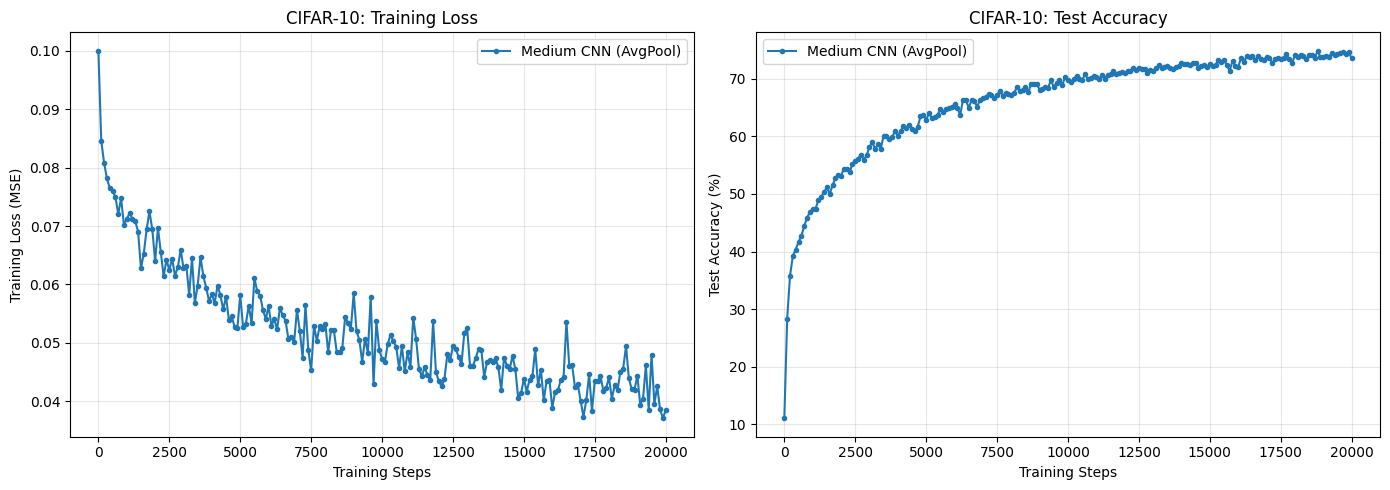

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(results_avgpool_10['step_indices'], results_avgpool_10['train_losses'], 
             label='Medium CNN (AvgPool)', marker='o', markersize=3, color='tab:blue')
axes[0].set_xlabel('Training Steps')
axes[0].set_ylabel('Training Loss (MSE)')
axes[0].set_title('CIFAR-10: Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(results_avgpool_10['step_indices'], results_avgpool_10['test_accs'], 
             label='Medium CNN (AvgPool)', marker='o', markersize=3, color='tab:blue')
axes[1].set_xlabel('Training Steps')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('CIFAR-10: Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Plot Training Curves - CIFAR-100

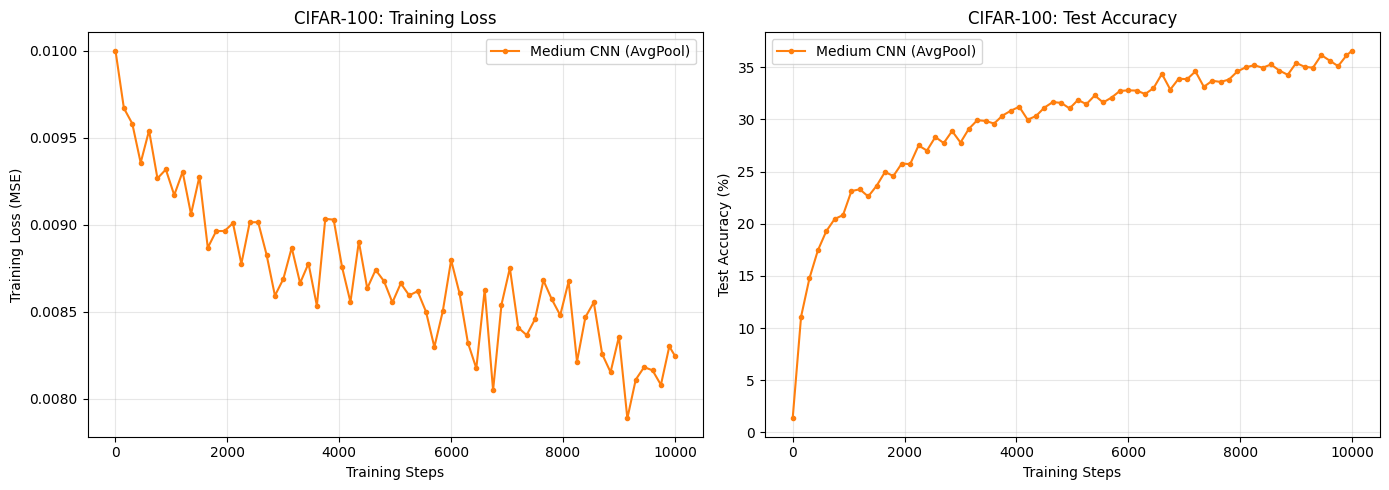

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(results_avgpool_100['step_indices'], results_avgpool_100['train_losses'], 
             label='Medium CNN (AvgPool)', marker='o', markersize=3, color='tab:orange')
axes[0].set_xlabel('Training Steps')
axes[0].set_ylabel('Training Loss (MSE)')
axes[0].set_title('CIFAR-100: Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(results_avgpool_100['step_indices'], results_avgpool_100['test_accs'], 
             label='Medium CNN (AvgPool)', marker='o', markersize=3, color='tab:orange')
axes[1].set_xlabel('Training Steps')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('CIFAR-100: Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Visualize Predictions on Test Set

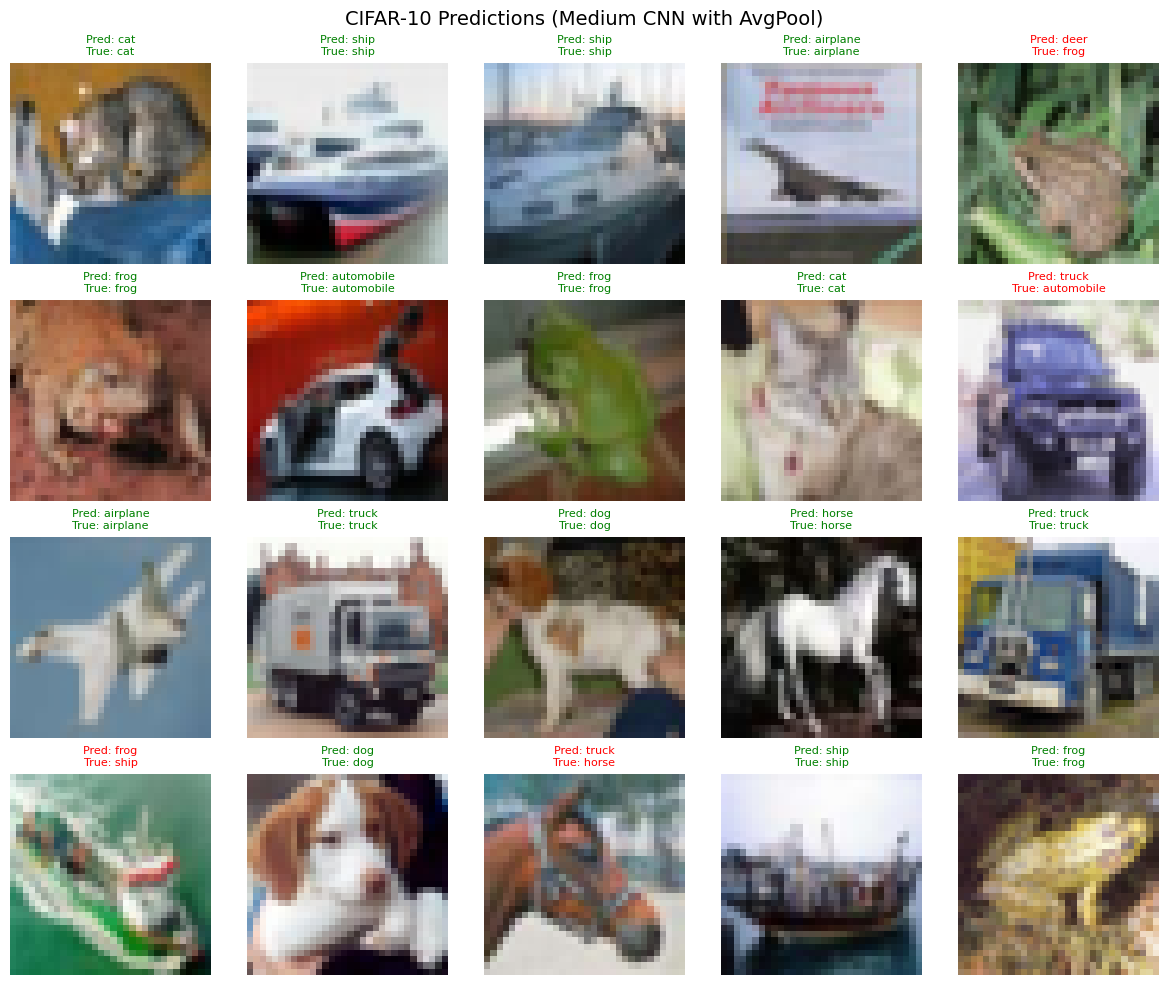

In [14]:
# CIFAR-10 predictions
model = results_avgpool_10['model']
w = results_avgpool_10['weights']

test_outputs = model(X_test_10[:20], w)
predicted_labels = jnp.argmax(test_outputs, axis=1)
true_labels = jnp.argmax(y_test_10[:20], axis=1)

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle('CIFAR-10 Predictions (Medium CNN with AvgPool)', fontsize=14)

for i in range(20):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(test_images_10[i])
    
    pred = int(predicted_labels[i])
    true = int(true_labels[i])
    color = 'green' if pred == true else 'red'
    
    axes[row, col].set_title(
        f'Pred: {cifar10_classes[pred]}\nTrue: {cifar10_classes[true]}',
        fontsize=8,
        color=color
    )
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


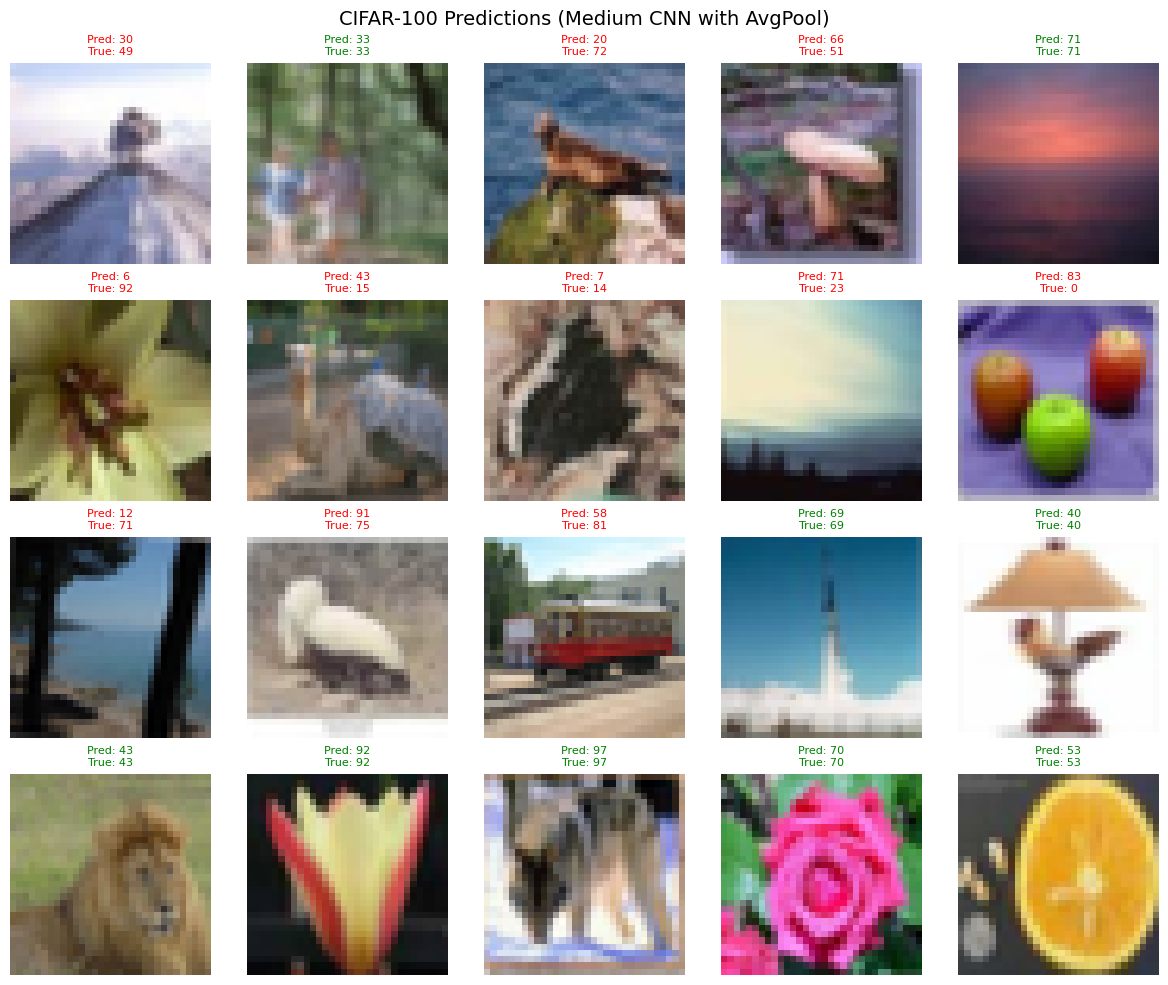

In [15]:
# CIFAR-100 predictions
model = results_avgpool_100['model']
w = results_avgpool_100['weights']

test_outputs = model(X_test_100[:20], w)
predicted_labels = jnp.argmax(test_outputs, axis=1)
true_labels = jnp.argmax(y_test_100[:20], axis=1)

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle('CIFAR-100 Predictions (Medium CNN with AvgPool)', fontsize=14)

for i in range(20):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(test_images_100[i])
    
    pred = int(predicted_labels[i])
    true = int(true_labels[i])
    color = 'green' if pred == true else 'red'
    
    axes[row, col].set_title(
        f'Pred: {pred}\nTrue: {true}',
        fontsize=8,
        color=color
    )
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
